# F1 Tire Friction Analysis

## Introduction

This is an amazing introduction

### We import the data

In [39]:
import numpy as np
import pickle
import matplotlib.pyplot as plt

In [45]:
## read Racing_data.pkl 
with open('Racing_data.pkl', 'rb') as f:
    data = pickle.load(f)

### 1a) Find the velocities

In [53]:

Racers = list(data.keys())
Lap = list(data[Racers[0]].keys())


for racer in Racers:
    for lap in Lap:
        data[racer][lap]['velocity'] = [] 
        for i in range(len(data[racer][lap]['distance'])):
            if i == 0:
                data[racer][lap]['velocity'].append(0)
            else:
                d_s = data[racer][lap]['distance'][i] - data[racer][lap]['distance'][i-1]
                d_t = data[racer][lap]['time'][i] - data[racer][lap]['time'][i-1]

                # avoid division by zero just in case
                v_t = d_s / d_t if d_t != 0 else 0  
                data[racer][lap]['velocity'].append(v_t)


### 1b ) Plot the velocity

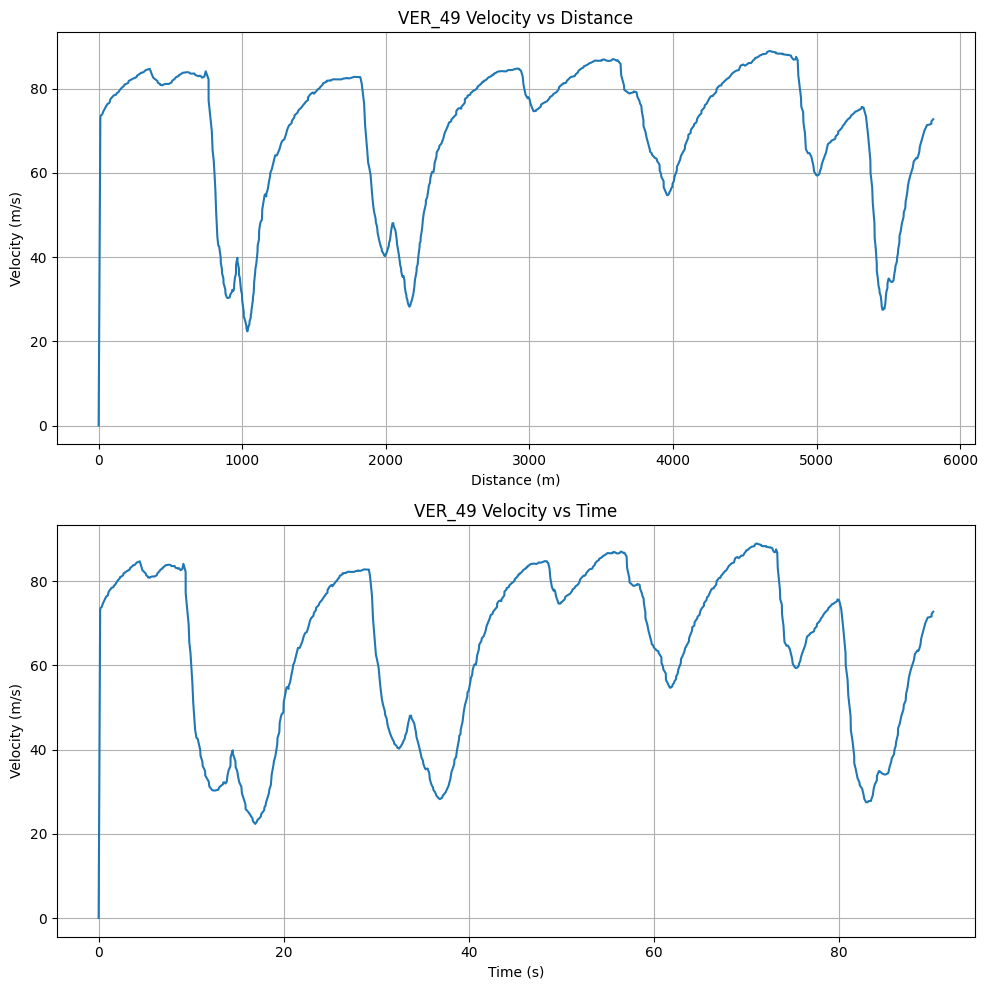

In [54]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(data["VER"]["49"]["distance"], data["VER"]["49"]["velocity"])
plt.xlabel("Distance (m)")
plt.ylabel("Velocity (m/s)")
plt.title("VER_49 Velocity vs Distance")
# plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(data["VER"]["49"]["time"], data["VER"]["49"]["velocity"])
plt.xlabel("Time (s)")
plt.ylabel("Velocity (m/s)")
plt.title("VER_49 Velocity vs Time")
# plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

## 2) Turn 15 of the race

In the British Grand Prix, there are 18 different corners in the Silverstone Circuit. 

![British Grand Prix Circuit with Corners](Racing_track.png)

To explore the tire friction, we will focus on turn 15. 

Assumptions:
- We will assume that turn 15 is shaped as a perfect half circle.
- We assume that the speed of the drivers is at the maximum velocity that the tires will allow. 

### 2) Free body diagram

Draw a free body diagram of the car in turn 15. We want to include the direction of motion, the centripetal force and the centrifugal force.
The centripetal force is the force that keeps the car moving in a circular path, while the centrifugal force is the apparent force that acts outward on a body moving around a center. What we mean with "apparent" is that the centrifugal force is actually not a real force, but rather a result of inertia.
You can label the forces F_c for the centripetal force and F_f for the centrifugal force.


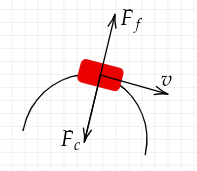

## 3) Finding the friction coefficient


### 3a) Plot velocities

Plot both the velocities of all the racers through corner 15 for all the laps. Then make another plot with the average velocity of all the racers.

Start by finding the average velocity in the corner for each racer. 

In [60]:
start_of_corner_15 = 4840
end_of_corner_15 = 5150

def start_end_indices(data, racer, lap, start=4840, end=5150):
    
    start_idx = np.where(data[racer][lap]["distance"] >= start)[0][0]
    end_idx = np.where(data[racer][lap]["distance"] <= end)[0][-1]
    return start_idx, end_idx


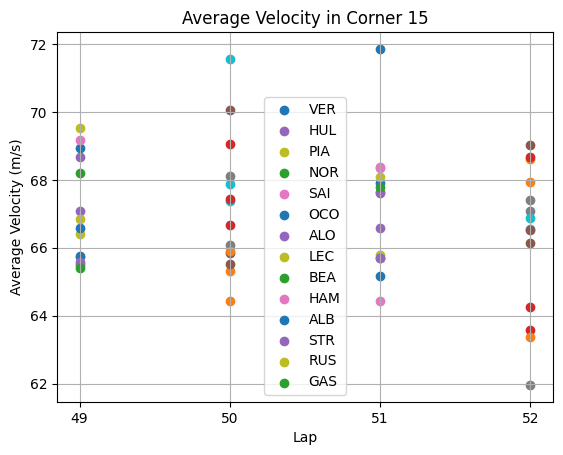

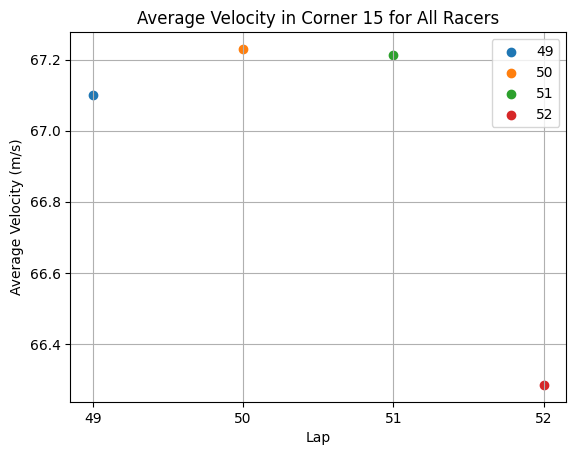

In [59]:
for racer in Racers:
    for lap in Lap:
        start, end = start_end_indices(data, racer, lap, start_of_corner_15, end_of_corner_15)
        average_velocity = np.mean(data[racer][lap]['velocity'][start:end+1])
        plt.scatter(lap, average_velocity,  label=racer if lap == "49" else "")
plt.xlabel("Lap")
plt.ylabel("Average Velocity (m/s)")
plt.title("Average Velocity in Corner 15")
plt.legend()
plt.grid()
plt.show()


for lap in Lap:
    average_velocity = 0
    for racer in Racers:
        start, end = start_end_indices(data, racer, lap, start_of_corner_15, end_of_corner_15)
        average_velocity += np.mean(data[racer][lap]['velocity'][start:end+1])
    average_velocity /= len(Racers)
    plt.scatter(lap, average_velocity, label=lap)
plt.xlabel("Lap")
plt.ylabel("Average Velocity (m/s)")
plt.title("Average Velocity in Corner 15 for All Racers")
plt.legend()
plt.grid()
plt.show()


### 3b) Finding friction

To find the friction coefficient, we have made some important assumptions:
1. The car is moving in a perfect half circle.
2. The ground is flat.
3. The driver is driving at maximum velocity, which the wheels can handle without slipping.

The third assumption allows us to use the formula for centripetal acceleration $a_c = \frac{v^2}{r}$, in order to find the friction coefficient $μ$.
Since the driver is driving at maximum velocity, at which the wheels can handle without slipping, we can say that the centripetal force, $F_c = ma _c$, is equal to the friction force, $F_f = μ N$. In other words, we can use Newtons third law to say that the centripetal force must equal to the friction force.

Find an expression for the friction coefficient $μ$, dependent on the average velocity, the radius and the mass.

Solution: 
$$
μ = \frac{v^2}{g r}
$$

### 3c) Linear Regression (Ordinary Least Squares)

Now that we have found a formula for the friction coefficient $μ$, we want to investigate whetehr it changes over time. In other words, does $μ$ vary with lap number?

To explore this, we use a linear model:
$$
μ = β ⋅ \text{Lap} + β_0
$$
Taken from the standard linear regression form:
$$
y = β X + ϵ
$$

Where $y$ is the target variable (friction coefficient), $X$ is the input variable (lap number), $β$ is the slope of the line, and $ϵ$ is the error term.

The OLS solution for the slope $β$ is in matrix form:
$$
β = X^T y(X^T X)^{-1}
$$
or in scalar form:
$$
β = \frac{Σ_{i=1}^{n} (x_i - \bar{x})(y_i - \bar{y})}{Σ_{i=1}^{n} (x_i - \bar{x})^2}
$$

In matrix form the design matrix $X$ will return us the $β$ coefficient, which contains both the slope and the intercept. The design matrix $X$ is defined as:
$$
X = \begin{bmatrix}
1 & x_1 \\
1 & x_2 \\
\vdots & \vdots \\
1 & x_n
\end{bmatrix}
$$
where $x_i$ is the lap number.

If you chose to use the scalar form, you will need to calculate the intercept separately:
$$
β_0 = \bar{y} - β \bar{x}
$$

In [63]:

distance = end_of_corner_15 - start_of_corner_15 # we imagine that corner 15 is a half circle
r = distance / np.pi # radius of the corner

In [64]:
def calculate_mu(velocity: float, r: float, g: float) -> float:
    """
    Calculate the friction coefficient (mu) using the formula:
    
    mu = velocity^2 / (g * r)
    
    where:
    
    Parameters
    ----------
    velocity: float
        The average velocity in m/s.
    r: float
        The radius of the turn in meters.
    g: float
        The acceleration due to gravity in m/s^2.
    
    Returns
    -------
    mu: float
        The friction coefficient.
    """
    return velocity**2 / (g * r)

In [67]:
#First create design matrix
X = []
y = []
g = 9.81  # acceleration due to gravity in m/s^2

for lap in Lap:
    mu_array = []
    for racer in Racers:
        start, end = start_end_indices(data, racer, lap, start_of_corner_15, end_of_corner_15)
        velocity = np.mean(data[racer][lap]['velocity'][start:end+1])

        mu = calculate_mu(velocity, r, g)
        mu_array.append(mu)
    X.append([1, int(lap)])  # Intercept term and lap number
    y.append(np.mean(mu_array))  # Average friction coefficient for the lap

X = np.array(X) #convert to numpy array
y = np.array(y) #convert to numpy array

# Now do the OLS calculation
beta = np.linalg.inv(X.T @ X) @ X.T @ y #calculate the beta coefficients

print("Coefficients (beta):", beta)

Coefficients (beta): [ 6.31203905 -0.03320835]


### 3d) Plot the results
You should now plot the results of the linear regression. The x-axis should be the lap number, and the y-axis should be the friction coefficient. Plot the linear regression line on top of a scatter plot of the friction coefficients.

You can easily scatter the individual friction coefficients by copying the velocity scatter plot and applying the calculate_mu function to the velocities.

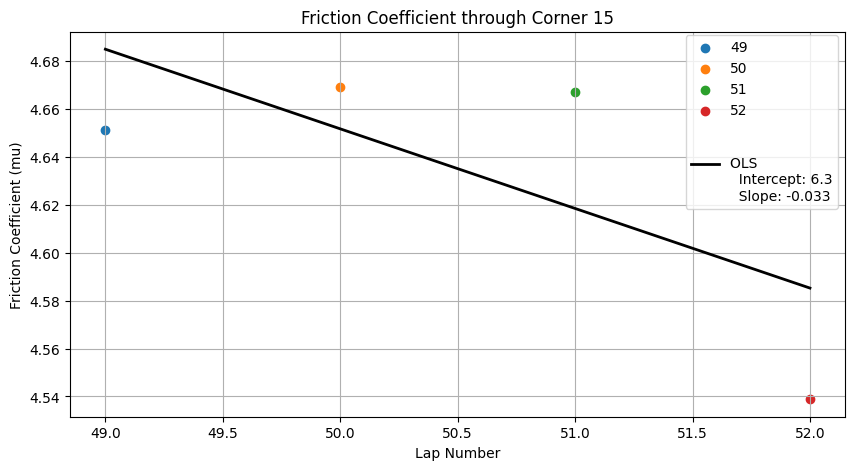

In [73]:

plt.figure(figsize=(10, 5))
for lap in Lap:
    average_velocity = 0
    for i, racer in enumerate(Racers):
        start, end = start_end_indices(data, racer, lap, start_of_corner_15, end_of_corner_15)
        average_velocity += np.mean(data[racer][lap]['velocity'][start:end+1])
    average_velocity /= len(Racers)
    plt.scatter(int(lap), calculate_mu(average_velocity, r, g), label=lap)


laps = np.array(Lap, dtype=int)

plt.plot(laps, beta[0] + beta[1] * laps, color='black',label=f'\n\nOLS \n  Intercept: {beta[0]:.2g}\n  Slope: {beta[1]:.2g}', linewidth=2)


plt.xlabel("Lap Number")
plt.ylabel("Friction Coefficient (mu)")
plt.title("Friction Coefficient through Corner 15")
plt.legend(ncol=1, bbox_to_anchor=(1, 1.01))
plt.grid()
plt.show()

## 4) Improving the model

